# Makine Öğrenmesi ile Zaman Serisi

## Problem ve Veri Setinin Tanınması

    Problemimiz mağaza ürün kırılımında talep tahmini yapabilmek.

**AMAÇ:** Farklı mağazlarda yer alan farklı ürünlerin üç ay sonrasındaki talep tahminlerini gerçekleştirmektir.

In [2]:
# Store Item Demand Forecasting Challenge
# https://www.kaggle.com/c/demand-forecasting-kernels-only
# !pip install lightgbm
# conda install lightgbm

In [3]:
# Kütüphanelerimizi import edelim;

import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

In [4]:
# Notebook ayarlarımızı yapalım;

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [5]:
# dataFrame kontrolü için bir fonksiyon tanımlayalım;

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.25, 0.50, 0.95, 0.75, 1]).T)

In [6]:
########################
# Loading the data
########################

train = pd.read_csv('datasets/demand_forecasting/train.csv', parse_dates=['date'])
test = pd.read_csv('datasets/demand_forecasting/test.csv', parse_dates=['date'])


# Kaggle submission örneği olan dosya;
sample_sub = pd.read_csv('datasets/demand_forecasting/sample_submission.csv')

In [7]:
train

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [8]:
test

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


In [9]:
# train ve test veri setimizi birleştirelim;

df = pd.concat([train, test], sort=False)
df

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN
...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0
44996,2018-03-28,10,50,NaN,44996.0
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0


In [10]:
#####################################################
# EDA
#####################################################

In [11]:
# Minimum ve maksimum tarihlere bakalım;

df["date"].min(), df["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [12]:
# Veri setimizi check edelim;

check_df(df)

##################### Shape #####################
(958000, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45000
id       913000
dtype: int64
##################

In [13]:
df.describe().T

# Ancak sales değişkenlerinin çeyrekliklerinin anlamlı olup olmadığını sorgulayabiliriz.

,count,mean,std,min,25%,50%,75%,max
store,958000.0,5.500000,2.872283,1.0,3.00,5.5,8.00,10.0
item,958000.0,25.500000,14.430877,1.0,13.00,25.5,38.00,50.0
sales,913000.0,52.250287,28.801144,0.0,30.00,47.0,70.00,231.0
id,45000.0,22499.500000,12990.525394,0.0,11249.75,22499.5,33749.25,44999.0


In [14]:
df.quantile([0, 0.01 ,0.05, 0.25, 0.50, 0.95, 0.75, 0.99, 1]).T

# çok uç bir aykırı değer yok gibi. (Bizim gözlemimiz !!!)

,0.00,0.01,0.05,0.25,0.50,0.95,0.75,0.99,1.00
store,1.0,1.00,1.00,3.00,5.5,10.00,8.00,10.00,10.0
item,1.0,1.00,3.00,13.00,25.5,48.00,38.00,50.00,50.0
sales,0.0,10.00,16.00,30.00,47.0,107.00,70.00,135.00,231.0
id,0.0,449.99,2249.95,11249.75,22499.5,42749.05,33749.25,44549.01,44999.0


In [15]:
# Kaç farklı mağaza var bir bakalım;

df[["store"]].nunique()

# 10 farklı mağaza varmış.

store    10
dtype: int64

In [16]:
# Kaç farklı ürün olduğuna bakalım;

df[["item"]].nunique()

# 50 farklı ürün varmış.

item    50
dtype: int64

In [17]:
# Her mağazaki eşsiz ürün sayısına bakalım;
# "Her mağaza her ürünü satıyor mu?" sorusunun cevabını arıyoruz.

df.groupby(["store"])["item"].nunique()

# Her mağazada her bir ürün satılıyormuş

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [18]:
# Her bir mağazadaki her bir ürünün ne kadar satıldığına bakalım;

df.groupby(["store", "item"]).agg({"sales": ["sum"]})

sales
                 sum
store item          
1     1      36468.0
      2      97050.0
      3      60638.0
      4      36440.0
      5      30335.0
...              ...
10    46    120601.0
      47     45204.0
      48    105570.0
      49     60317.0
      50    135192.0

[500 rows x 1 columns]

In [19]:
# Her bir mağazadaki her bir ürünün betimsel istatistiklerini getirelim;

df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

In [20]:
#####################################################
# FEATURE ENGINEERING
#####################################################

In [21]:
# Verimize bir head atalım;

df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [22]:
# Date değişkeni üzerinden feature'lar türetecek bir fonksiyon oluşturalım;

def create_date_features(df):
    # date değişkeni içerisinden ayı almasını istiyoruz;
    df['month'] = df.date.dt.month
    # date değişkeni içerisinden ayın kaçıncı günü olduğunu getirmesini ifade ediyoruz;
    df['day_of_month'] = df.date.dt.day
    # date değişkeni içerisinden yılın kaçıncı günü olduğunu getirmesini ifade ediyoruz;
    df['day_of_year'] = df.date.dt.dayofyear
    # date değişkeni içerisinden yılın kaçıncı haftasını olduğunu getirmesini ifade ediyoruz;
    df['week_of_year'] = df.date.dt.weekofyear
    # date değişkeni içerisinden haftanın kaçıncı günü olduğunu getirmesini ifade ediyoruz;
    df['day_of_week'] = df.date.dt.dayofweek
    # date değişkeni içerisinden yılı almasını istiyoruz;
    df['year'] = df.date.dt.year
    # date değişkeni içerisinden haftasonu mu değil mi, onu getirmesini istiyoruz;
    df["is_wknd"] = df.date.dt.weekday // 4
    # ayın başlangıcı mı, onu getirmesini istiyoruz;
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    # ayın sonu mu, onu getirmesini istiyoruz;
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

In [23]:
# veri setimizi tanımladığımız fonksiyondan geçirelim;

df = create_date_features(df)
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0


In [24]:
# Verimizi; mağaza, ürün sonrasında da ay bazında kırılımını gösterelim;

df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

# Verimiz aylık bazda daha iyi bir şekilde ifade edilebilir hale geldi.

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

In [25]:
########################
# Lag/Shifted Features
########################

    Bu bölümdeki feature üretme işlemimizi bağımlı değişken üzerinden yapacağız. Bağımlı değişken üzerinden feature üretirken bağımlı değişkeni istediğimiz (işimize en uygun) bir şekilde kaydıracağız.

Bu case için tahmin periyodumuz 3 aylık olduğu için üreteceğimiz periyotler 3 aylık periyotlar odağında planlanmalıdır.

In [26]:
# Burada mağaza, ürün ve tarih verimizin sıralı olduğundan emin olmalıyız;

df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0


In [27]:
# Yukarıda bağımlı değişkenimizi kaydırmaktan bahsetmiştik. Bunun ne manaya geldiğine birlikte göz atalım;

# Geçici bir df oluşturacağız o sebeple bir atama yapmıyoruz;
pd.DataFrame({"sales": df["sales"].values[0:10],
              "lag1": df["sales"].shift(1).values[0:10],
              "lag2": df["sales"].shift(2).values[0:10],
              "lag3": df["sales"].shift(3).values[0:10],
              "lag4": df["sales"].shift(4).values[0:10]})

# lag işlemi için ".shift()" metodu kullanılır.

,sales,lag1,lag2,lag3,lag4
0,13.0,NaN,NaN,NaN,NaN
1,11.0,13.0,NaN,NaN,NaN
2,14.0,11.0,13.0,NaN,NaN
3,13.0,14.0,11.0,13.0,NaN
4,10.0,13.0,14.0,11.0,13.0
5,12.0,10.0,13.0,14.0,11.0
6,10.0,12.0,10.0,13.0,14.0
7,9.0,10.0,12.0,10.0,13.0
8,12.0,9.0,10.0,12.0,10.0
9,9.0,12.0,9.0,10.0,12.0


    Bakınız yukrıdaki ilk sütun bizim verimizin sales değişkeni iken, bir sağındaki sütun sales değişkeninin 1 birim aşağı kaymış halidir. Buna lag kavramı denir. Yani verimizi 1 lag kaydırmış olduk.

Diğer sütunlarda da verimizi sırasıyla 2, 3, 4 lag kaydırdık.

**Kaydırma işlemi yapıldığı için** kaydırdığımız lag kadar veri (olmamasından kaynaklı olarak) NaN döner.

### **NOT !!!!** 

Yukarıda yaptığımız kaydırma işlemi neticede bağımlı değişkenin kendisidir. Bu sebeple modelimiz veriyi aşırı öğrenebilir. Bu aşırı öğrenmenin önüne geçmek gerekir.

In [28]:
# Verimizin hangi mağazada hangi üründen kaçar tane sattığını getirelim;

df.groupby(["store", "item"])['sales'].head()

# head attığımız için az veri gözüküyor.
# Bu veri ilk veri setinin neredeyse aynısı gibidir :)

0         13.0
1         11.0
2         14.0
3         13.0
4         10.0
          ... 
911174    33.0
911175    37.0
911176    46.0
911177    51.0
911178    41.0
Name: sales, Length: 2500, dtype: float64

In [29]:
# Bu veriyi bir lag kaydıralım;

df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(1))

0         NaN
1        13.0
2        11.0
3        14.0
4        13.0
         ... 
44995     NaN
44996     NaN
44997     NaN
44998     NaN
44999     NaN
Name: sales, Length: 958000, dtype: float64

    Yukarıda aşırı öğrenmenin önüne geçmemiz gerektiğinden bahsetmiştik. Eğer ki gecikmiş verimizin üzerinde random noise eklersek, verinin rasgeleliliği sağlanacak ama özünde o pattern'i (örüntüyü) yine de taşıyacaktır.

In [30]:
# Random Noise
########################

# Verimize random noise sağlayacak bir fonksiyon tanımlayalım;

def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [31]:
# Verimizi sistemetik bir şekilde istediğimiz lag kadar kaydıracak ve random noise ekleyecek bir fonksiyon tanımlayalım;

def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [32]:
# Verimizi istediğimiz laglarda kaydırıp sonrasında random noise ekleyelim;

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

# 3 aylık kaydırdık, 3 aylık + 1 haftalık kaydırdık ...
# Genel olarak kaydıracağımız lag'leri 3 aylık periyotların odağında seçtik.

In [33]:
# Verimizi check edelim;

df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,42.431257,56.631821,66.460947,70.330014,71.059121,82.610839,79.107353,60.707878,98.362804,70.048439
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,64.716176,51.787187,65.989576,62.453178,75.476839,80.587283,80.725800,77.609944,78.727827,69.656977
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,56.593354,66.802384,71.805516,62.702162,71.117353,86.257673,81.000693,66.647215,100.333340,74.201085
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,73.435079,77.709164,73.450428,66.666458,65.999478,79.849484,90.173921,68.205241,81.645383,82.848934


### Farkındalık Başlangıç

In [34]:
df[(df["store"] == 1) & (df["item"] == 1) & (df["id"].isnull())]

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14.0,NaN,12,27,361,52,2,2017,0,0,0,25.295457,20.992820,15.453604,24.134840,22.875355,29.346213,48.970849,16.228155,22.798279,14.198887
1822,2017-12-28,1,1,19.0,NaN,12,28,362,52,3,2017,0,0,0,22.647814,22.117229,27.416290,26.473738,26.656578,15.042034,26.216994,19.775742,23.573257,15.765521
1823,2017-12-29,1,1,15.0,NaN,12,29,363,52,4,2017,1,0,0,27.333240,30.635974,26.282884,29.022134,35.554168,28.773054,28.605610,25.357091,40.704656,25.924363
1824,2017-12-30,1,1,27.0,NaN,12,30,364,52,5,2017,1,0,0,27.994367,38.280800,26.663072,25.618122,26.280281,38.514679,31.467642,14.859473,32.599730,10.974839


In [35]:
df[(df["store"] == 1) & (df["item"] == 2) & (df["id"].isnull())]

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
18260,2013-01-01,1,2,33.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18261,2013-01-02,1,2,43.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18262,2013-01-03,1,2,23.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18263,2013-01-04,1,2,18.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18264,2013-01-05,1,2,34.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20081,2017-12-27,1,2,55.0,NaN,12,27,361,52,2,2017,0,0,0,56.633124,62.580657,55.891660,68.599327,75.329621,65.268902,64.654173,38.155369,64.618857,33.113877
20082,2017-12-28,1,2,50.0,NaN,12,28,362,52,3,2017,0,0,0,55.731994,65.097374,67.682346,59.940845,55.279424,65.481423,65.158727,55.448124,68.482141,35.144377
20083,2017-12-29,1,2,50.0,NaN,12,29,363,52,4,2017,1,0,0,65.388893,67.884169,60.646746,66.414728,64.875059,91.267607,81.643058,37.743385,85.026096,32.271997
20084,2017-12-30,1,2,56.0,NaN,12,30,364,52,5,2017,1,0,0,76.812439,83.840239,75.959101,68.019408,79.175157,70.251734,85.216201,45.732746,92.686197,40.989895


### Farkındalık Bitiş

In [36]:
########################
# Rolling Mean Features
########################

    Bu bölümdeki feature üretme işlemimizi yine bağımlı değişken üzerinden yapacağız. Daha önce trend belirlerken veya tahminde bulunurken hareketli ortalamalardan faydalanmıştık. Bu bölümde de hareketli ortalamalardan hareketle feature üreteceğiz.

In [37]:
# Örnek olarak;
# Aşağıda veri ve hareketli ortalamasının (kaç değerin ortalamasının alınacağına göre) alınmış hali bulunmaktadır

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].rolling(window=5).mean().values[0:10]})

# Hareketli ortalamayı ".rolling()" metodu ile 
# kaç değerin ortalamasının alınacağı ise "window=" argümanı ile belirtilir.

,sales,roll2,roll3,roll5
0,13.0,NaN,NaN,NaN
1,11.0,12.0,NaN,NaN
2,14.0,12.5,12.666667,NaN
3,13.0,13.5,12.666667,NaN
4,10.0,11.5,12.333333,12.2
5,12.0,11.0,11.666667,12.0
6,10.0,11.0,10.666667,11.8
7,9.0,9.5,10.333333,10.8
8,12.0,10.5,10.333333,10.6
9,9.0,10.5,10.000000,10.4


Burada hareketli ortalamaları GEÇMİŞ bilgiyi toplu ve smooth bir şekilde yansıtma maksatlı hareket ediyoruz. Lakin yukarıdaki örnekte geçmiş bilgiyi değil, bugünün değerinin de ortalaması alınarak hareketli ortalama alınmaktadır.

    Bakınız; roll2 sütunun 1. indeksteki değeri, sales sütununun 0. ve 1. indekslerinin ortalamasını yansıtmaktadır.

### DİKKAT!!!

Dolayısıyla sales sütunun bir lag kaydırıldıktan sonra hareketli ortalamasının alınması gerekmektedir.

In [38]:
# Yukarıdaki uyarımızı görsel olarak tablo üzerinde açıklayalım;

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})

,sales,roll2,roll3,roll5
0,13.0,NaN,NaN,NaN
1,11.0,NaN,NaN,NaN
2,14.0,12.0,NaN,NaN
3,13.0,12.5,12.666667,NaN
4,10.0,13.5,12.666667,NaN
5,12.0,11.5,12.333333,12.2
6,10.0,11.0,11.666667,12.0
7,9.0,11.0,10.666667,11.8
8,12.0,9.5,10.333333,10.8
9,9.0,10.5,10.333333,10.6


In [39]:
# Verimizi sistematik bir şekilde bir lag kaydıracak ve 
# daha sonrasında hareketli ortalama hesaplayacak bir fonksiyon yazalım;

def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

In [40]:
# Verimize tanımladığımız fonksiyonu uygulayalım;

# Burada yıllık ve 1.5 yıllık hareketli ortalama almak istiyoruz;
df = roll_mean_features(df, [365, 546])
df

# Farklı aralıklar da girilerek denemeler yapılabilir.

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,42.431257,56.631821,66.460947,70.330014,71.059121,82.610839,79.107353,60.707878,98.362804,70.048439,84.574531,85.568331
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,64.716176,51.787187,65.989576,62.453178,75.476839,80.587283,80.725800,77.609944,78.727827,69.656977,86.820319,86.154331
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,56.593354,66.802384,71.805516,62.702162,71.117353,86.257673,81.000693,66.647215,100.333340,74.201085,88.585056,85.105564
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,73.435079,77.709164,73.450428,66.666458,65.999478,79.849484,90.173921,68.205241,81.645383,82.848934,85.993401,87.161943


        NOT !!!
        Hareketli ortalama feature'si üretirken bir shift alınması gerekmetedir.

In [41]:
########################
# Exponentially Weighted Mean Features
########################

    Bu bölümdeki feature üretme işlemimizi yine bağımlı değişken üzerinden yapacağız. Daha önce trend belirlerken veya tahminde bulunurken üssel hareketli ortalamalardan faydalanmıştık. Bu bölümde de üssel hareketli ortalamalardan hareketle feature üreteceğiz.

Hareketli ortalamaya benzer bir mantıkla **single exponential smoothing** metodu ile hareket ediyoruz.

SES modelinde alpha ile yakın gelecekteki değerlere ağırlık veriliyordu.

<p align="center">
  <img src="grafikler/ts_4.png" height=75>
</p>

Yakın gelecekti değere verdiğim önem ne kadar yakınsa alpha'nın 1'e o kadar yakın olması gerekirdi.

In [42]:
# Yine örnek bir df'de ne demek istediğimizi anlatalım;

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm02": df["sales"].shift(1).ewm(alpha=0.1).mean().values[0:10]})

,sales,roll2,ewm099,ewm095,ewm07,ewm02
0,13.0,NaN,NaN,NaN,NaN,NaN
1,11.0,NaN,13.000000,13.000000,13.000000,13.000000
2,14.0,12.0,11.019802,11.095238,11.461538,11.947368
3,13.0,12.5,13.970201,13.855107,13.287770,12.704797
4,10.0,13.5,13.009702,13.042750,13.084686,12.790637
5,12.0,11.5,10.030097,10.152137,10.920146,12.109179
6,10.0,11.0,11.980301,11.907607,11.676595,12.085878
7,9.0,11.0,10.019803,10.095380,10.502722,11.686057
8,12.0,9.5,9.010198,9.054769,9.450748,11.214433
9,9.0,10.5,11.970102,11.852738,11.235259,11.342672


ewm099 sütunun 2. indeksindeki (3. satır) 11.019 değeri şu şekilde oluşmuştur;

        (11 * 0.99) + (13 * 0.01) = 11.019

11 değeri sales sütunundaki 1. indeksten, 13 değeri ise sales sütunundaki 0. indeksten gelmektedir.

In [43]:
# Burada belirleyeceğimiz alpha ve öteleyeceğimiz lag değerlerine göre feature üretecek bir fonksiyon tanımlayalım;

def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [44]:
# Üretilecek feature'lara ilişkin alpha ve lag değerlerini tanımlayalım;

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

    Yukarıda yine deneyeceğimiz lag'ları model bazında 3 aylık periyotlar odağında seçtik.

In [45]:
# Fonksiyonu modelimize uygulayalım;

df = ewm_features(df, alphas, lags)
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,42.431257,56.631821,66.460947,70.330014,71.059121,82.610839,79.107353,60.707878,98.362804,70.048439,84.574531,85.568331,41.561777,54.028375,66.387487,67.349358,81.895724,112.421502,66.744209,94.617783,71.979468,42.244368,54.197995,65.849785,66.785772,81.777579,112.682169,67.473304,92.561560,71.115472,43.955442,54.879654,64.996171,65.861563,81.488819,112.703381,68.859556,89.361543,69.838571,46.091666,55.909793,64.428121,65.144155,81.162051,112.055216,70.090358,87.248414,69.116907,51.309755,58.648702,64.033868,64.335072,80.828687,109.036310,71.734958,85.489012,68.933911
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,64.716176,51.787187,65.989576,62.453178,75.476839,80.587283,80.725800,77.609944,78.727827,69.656977,86.820319,86.154331,61.928089

In [46]:
########################
# One-Hot Encoding
########################

    Buradaki mağazaları, bu mağaza 1 ya da değil, mağaza 10 ya da değil gibi one-hot encoderdan geçirmemiz gerekir. Her ne kadar bu değerler sağısal olsa da büyüklük içeriyor. Bu sebeple one-hot encode edilmeli.

    Aynı durum, item ve ay değişkenleri için de geçerlidir.

In [47]:
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])
df

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,13.0,NaN,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,11.0,NaN,2,2,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,14.0,NaN,3,3,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,13.0,NaN,4,4,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,10.0,NaN,5,5,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [48]:
########################
# Converting sales to log(1+sales)
########################

    Burayı yapıp yapmamak kullanıcıya kalmıştır. Zira burada bir sınıflandırma değil regresyon problemi söz konusudur. Regresyon problemi olduğu için bağımlı değişkenimiz 1 ve 0'dan farklı değerlerdir. Model çalışma süresini kısaltma adına bağımlı değişkenin logaritması alınır. 
    
Burada yapma sebebimiz hem böyle bir yöntem olduğunun farkındalığını oluşturmak, hem de model çalışma süremizi kısaltmak istememizdir.

In [49]:
# sales değişkeninin 

df['sales'] = np.log1p(df["sales"].values)
df

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,2.639057,NaN,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,2.484907,NaN,2,2,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,2.708050,NaN,3,3,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,2.639057,NaN,4,4,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,2.397895,NaN,5,5,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [50]:
# log1p fonksiyonunun anlamı; 
from math import e

print(e)
np.log1p(e-1)

# görüldüğü üzere log1p içerisindeki değere 1 ekleyerek e tabanında logaritma alır.
# yani ln(1 + x)'dir.

2.718281828459045


1.0

In [51]:
########################
# Custom Cost Function
########################

    Makine öğrenmesinde model değerlendirirken bir takım cost fonksiyonlarına bakıyoruz.

Daha önceden gözümüze çarpmış olan birkaç cost fonksiyonunu hatırlayalım;

* MAE
* MSE
* RMSE
* SSE

Lakin zaman serilerin farklı bir cost fonksiyonu kullanacağız; bu sMAPE olacak.

* MAE: mean absolute error
* MAPE: mean absolute percentage error
* SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

##### sMAPE Formülü

<p align="center">
  <img src="grafikler/ts_15.png" height=150>
</p>

In [52]:
# Aşağıda sMAPE hesaplayacak bir formül tanımlıyoruz;

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

# Burada da yukarıdaki formülü LightGBM'de kullanabileceğimiz bir formata getiriyoruz.

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

Not :Yukarıdaki formülleri kaggle'dan bulduk ve buraya getirdik. Formülü anlamak için araştırma yapabilirsiniz. Biz burada bir kütüphaneden import etmişiz gibi davranacağız.

In [53]:
########################
# Time-Based Validation Sets
########################

    Makine öğrenmesi modelini kurduğumuzda kurduğumuz modelin iyiliği test etmemiz gerekir. Bu sebeple train veri setimizi, time-based bir şekilde train ve validate (test de denebilir.) olarak 2'ye ayıracağız.

Yukarıda validate tanımı bilerek kullanılmıştır. Zira kaggle'ın verdiği test veri seti ile isim karmaşası olsun istemedik.

In [54]:
# csv'den okuttuğumuz train verimize bir bakalım;

train

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


    Veri "01-01-2013" tarihinde başlayıp "31-12-2017" tarihinde bitmektedir.

In [55]:
# csv'den okuttuğumuz test verimize bir bakalım;

test

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


    Bizden "01-01-2018" tarihinden başlayıp, "31-03-2021" tarihine kadar forecast yapmamız istenmektedir.

In [56]:
# train seti olarak 2017'nin başına kadar (2016'nın sonuna kadar) ki tarihi alıyoruz. 
# Zira 2018'in ilk üç ayını tahmin etmeye çalışacağız.
# Bu sebeple tahmin başarımızı 2017 yılının ilk üç ayından ölçeceğiz.

# train data setimizi oluşturalım;
train = df.loc[(df["date"] < "2017-01-01"), :]

# validation data setimizi oluşturalım;
# 2017'nin ilk 3'ayı validasyon seti.
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

In [57]:
df.head(2)

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,2.639057,NaN,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,2.484907,NaN,2,2,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [58]:
# Bağımsız değişkenlerimi seçelim;

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

# Year'ın da tek başına bir şey ifade etmeyeceğini düşünüyoruz. Düşünen var ise modele ekleyerek bakabilir :) (sayısal bir değişken)
# date değişkenini LightGBM iyi analiz edemeyebilir.
# "id" ile ilgilenmiyoruz.
# "sales" bizim bağımlı değişkenimiz.

In [59]:
# test ve val data setlerimizi hazırlayalım;

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

In [60]:
# hangi sette ne kadar değişken var bir göz atalım;

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 142), (45000,), (45000, 142))

In [61]:
########################
# LightGBM ile Zaman Serisi Modeli
########################

LightGBM tek başına iyi bir makine öğrenmesi modeli olup, uzmanlık gerektiren bir algoritmadır. Daha önceki notlarımızı da takip ettiyseniz, orda detaylıca bahsetmiştik.

Bu bölümde verilerimizi LightGBM ile tahmin ediyor olacağız. LightGBM algoritmasının (bir çok makine öğrenmesi algoritmasında olduğu gibi) hiper parametrelerinin optimizasyonunun yapılması gerekmektedir. Lakin bu notebook'un ön gerekliliği olarak feature engineering ve machine learning notebooklarına da bakmalısınız. Orada hiper parametre optimizasyonunu ayrıntılı bir şekilde tekrar tekrar göstermiştik.

    Dolayısıyla burada notebook'umuzu çok uzun tutmamak adına optimize edilmiş hiper parametreler ile modelimizi kuruyor olacağız.

In [62]:
# OPTİMİZE EDİLMİŞ hiper parametrelerimizi tanımlayalım;

# LightGBM parameters
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

# Bizler yukarıda yine de hangi hiper parametre ne işe yarıyor bunu açıklıyor olacağız;

# num_leaves            : Her bir öğrenicinin (ağacın) kaç yaprak ileri gideceğini söyler.
# learning_rate         : Öğrenme hızıdır.
# feature_fraction      : Değişkenlerin %'de kaçını alacağımızı söyleriz.
# max_depth             : Her ağacın derinliğini ifade eder.
# verbose               : Çıktıları hangi düzeyde getireceğini söyler.
#                         Dilerseniz 1, 2, 3 ... olarak değiştirip farkı görebilirsiniz.
# num_boost_round       : Boosting iterasyon (döngü) sayıdır.
# early_stopping_rounds : ?
# nthread               : İşlemcilerin tamamının kullanılıp kullanılmayacağını ifade eder.

In [ ]:
# Literatürde bir çok farklılık vardır. Burada karşılaşacağımız hata değerlendirme metriklerini derledik.

# metric mae: l1, absolute loss, mean_absolute_error, regression_l1
# mse: l2, square loss, mean_squared_error, mse, regression_l2, regression
# rmse, root square loss, root_mean_squared_error, l2_root
# mape, MAPE loss, mean_absolute_percentage_error

# Her bir satır aynı metriği ifade eder lakin bu isimlerde karşılaşılabilir.

In [ ]:
# Hiper paramtrelerin karşılaşabileceğimiz diğer isimlerine bakalım;

# num_leaves: bir ağaçtaki maksimum yaprak sayısı
# learning_rate: shrinkage_rate, eta
# feature_fraction: rf'nin random subspace özelliği. her iterasyonda rastgele göz önünde bulundurulacak değişken sayısı.
# max_depth: maksimum derinlik
# num_boost_round: n_estimators, number of boosting iterations. En az 10000-15000 civarı yapmak lazım.

In [ ]:
# Diğer hiper parametrelerimize de bakalım;

# early_stopping_rounds: validasyon setindeki hata metriği belirli bir early_stopping_rounds'da ilerlemiyorsa yani
# yani hata düşmüyorsa modellemeyi durdur.
# early_stopping_rounds, hem train süresini kısaltır hem de overfit'e engel olur.
# nthread: num_thread, nthread, nthreads, n_jobs

LGBM'i daha detaylı anlamak için, makine öğrenmesi notebook'larını iyi bir şekilde okuduğunuzdan emin olduktan sonra aşağıdaki kaynaktan faydalanabilirsiniz;

https://neptune.ai/blog/lightgbm-parameters-guide

In [63]:
# LightGBM kütüphanesinde modele özel bir data yapısı vardır. Bunu dataframe benzeri bir yapı olarak adlandırabiliriz.
# LightGBM bu yapı ile daha hızlı bir şekilde çalışacağını iddia etmektedir.
# Bu sebeple burada modelimizi kurarken bu yapı ile çalışacağız.

# Train dataset'imizi hazırlayalım;
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

# lgb kütüphanesi içerisinden  "Dataset()" nesnesini getiriyoruz.
# İçerisine bağımlı ve bağımsız değişkenlerimizi giriyoruz.
# Özellik olarak da içerisine değişken isimlerini gönderiyoruz.

# Validation dataseti'imizi de hazırlayalım;
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

# Train'den farklı olarak referans alacağı bir dataset (lgbtrain)'i gönderiyoruz.

In [64]:
# Modelimizi oluşturalım ve train edelim;

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)
                  
# "feval=" argümanı özel bir cost fonksiyonu olup olmadığını sorar. Bu case'de evet var. Yukarıda tanımlamıştık.
# "verbose_eval=" her 100 iterasyonda bize çıktı vermesi gerektiğini söylüyoruz.

# num_boost_round: hatayı düşürmek için modelin kaç kere iterasyona sokulacağıdır dersek;
# çok da yanlış bir tanımlama yapmış olmayız. Lakin burada bir tehlike var model veriyi aşırı öğrenebilir.

# "early_stopping_rounds" ile de validation verisetinde artık hata düşmüyorsa, 
# "num_boost_round"u nerede durduracağımızı ifade ediyoruz.

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 200 rounds
[100]	training's SMAPE: 17.5805	valid_1's SMAPE: 17.4577
[200]	training's SMAPE: 14.57	valid_1's SMAPE: 14.9193
[300]	training's SMAPE: 14.0135	valid_1's SMAPE: 14.4398
[400]	training's SMAPE: 13.7974	valid_1's SMAPE: 14.2799
[500]	training's SMAPE: 13.6664	valid_1's SMAPE: 14.1569
[600]	training's SMAPE: 13.5702	valid_1's SMAPE: 14.0495
[700]	training's SMAPE: 13.5002	valid_1's SMAPE: 13.9737
[800]	training's SMAPE: 13.4426	valid_1's SMAPE: 13.9133
[900]	training's SMAPE: 13.394	valid_1's SMAPE: 13.8676
[1000]	training's SMAPE: 13.3509	valid_1's SMAPE: 13.835
Did not meet early stopping. Best iteration is:
[1000]	training's SMAPE: 13.3509	valid_1's SMAPE: 13.835


<p align="center">
  <img src="grafikler/ts_16.png" height=75>
</p>

    Bakınız yukarıda fotoğraftaki gibi bir çıktı ile karşılaşıyoruz. "early_stopping_rounds" hiç bir 200'lük iterasyonda çalışmamış. Yani "num_boost_round"un demekki arttırılması gerekiyor.

In [66]:
# Şimdi elimizdeki model ile modelimizi validate etmek için ayırdığımız,
# 2017'nin ilk 3 aylık kısmını tahmin edelim;

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [67]:
# Tahminlerimizin hatasına bakalım;

smape(np.expm1(y_pred_val), np.expm1(Y_val))

# Çıktı yukarıdaki ile aynı. Burada sadece bağımsız olarak da model validation'ını göstermek istedik.

# Sadece şuraya odaklanmak gerekir;
# Yukarıda sales değişkeninin logaritmasını almıştık.

# "np.expm1()" fonksiyonu "np.log1p()" fonksiyonunun tersidir.
# Yani logritmanın tersidir.

13.834988700327909

In [68]:
########################
# Değişken Önem Düzeyleri
########################

In [69]:
# Değişken önemini grafiksel olarak gösterebilecek bir fonksiyon tanımlayalım;

def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

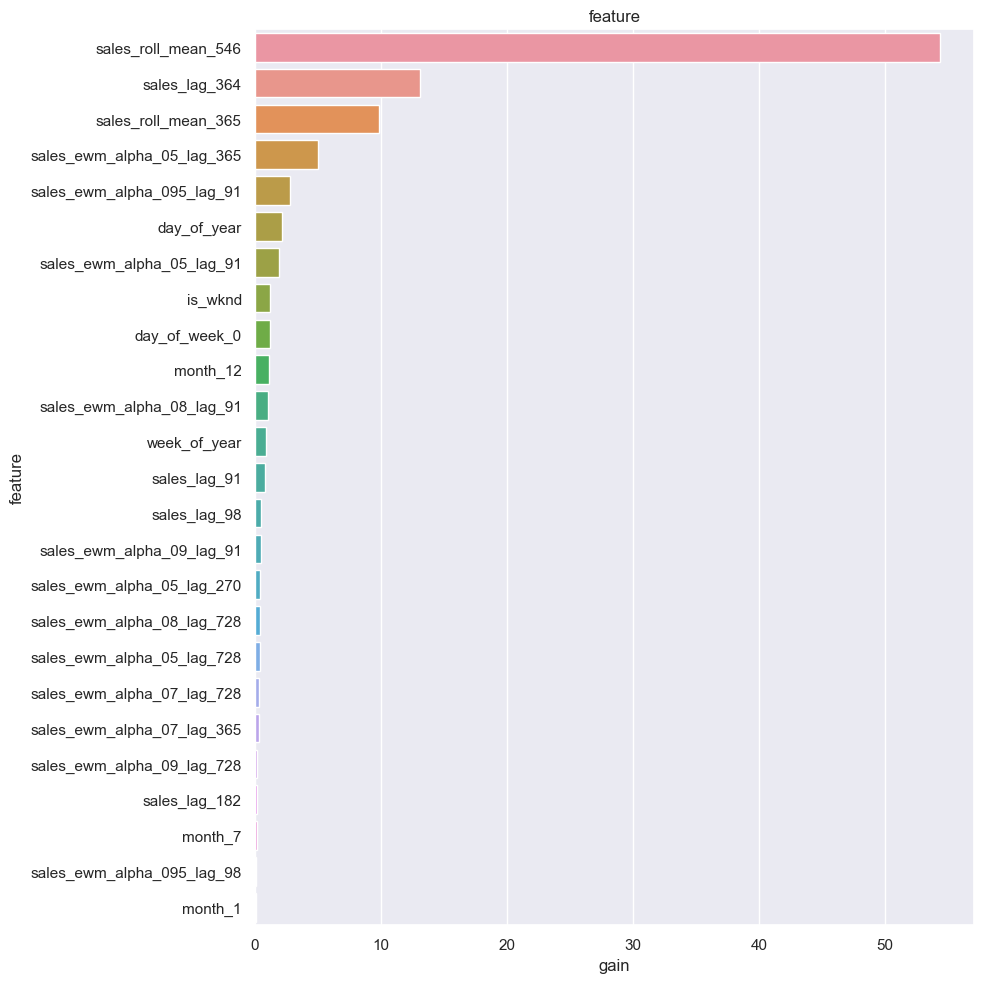

,feature,split,gain
17,sales_roll_mean_546,961,54.369193
13,sales_lag_364,1251,13.070303
16,sales_roll_mean_365,627,9.866152
60,sales_ewm_alpha_05_lag_365,382,5.030346
18,sales_ewm_alpha_095_lag_91,79,2.771849
...,...,...,...
78,item_6,0,0.000000
111,item_39,0,0.000000
86,item_14,0,0.000000
115,item_43,0,0.000000


In [70]:
# Değişkenlerimizin önem düzeylerine bakalım;

plot_lgb_importances(model, num=30, plot=True)

In [72]:
# Fonskiyon çıktısı olan tabloyu bir değişkene atayalım;
feat_imp = plot_lgb_importances(model, num=200)

                        feature  split       gain
17          sales_roll_mean_546    961  54.369193
13                sales_lag_364   1251  13.070303
16          sales_roll_mean_365    627   9.866152
60   sales_ewm_alpha_05_lag_365    382   5.030346
18   sales_ewm_alpha_095_lag_91     79   2.771849
..                          ...    ...        ...
78                       item_6      0   0.000000
111                     item_39      0   0.000000
86                      item_14      0   0.000000
115                     item_43      0   0.000000
71                      store_9      0   0.000000

[142 rows x 3 columns]


In [75]:
# Önemi (gain, ilgili feature'nin burada modele olan katkısı manasına geliyor) "0" olanları seçelim;

importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values
importance_zero

array(['month_4', 'month_8', 'store_3', 'sales_lag_728', 'item_50',
       'store_4', 'is_month_start', 'item_48', 'item_2', 'item_46',
       'store_10', 'item_12', 'item_11', 'item_19', 'item_20', 'item_21',
       'item_24', 'item_26', 'item_9', 'item_29', 'item_30', 'item_31',
       'item_32', 'item_33', 'item_7', 'item_35', 'item_6', 'item_39',
       'item_14', 'item_43', 'store_9'], dtype=object)

In [77]:
# Önemli feature'ları bulalım;

imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)

# 99 featurenin önemi direk olarak 0'mış.

111

In [78]:
########################
# Final Model
########################

In [79]:
# Yukarıda bütün hiper parametrelerimize karar verdik,
# Şimdi son olarak bütün veriyi kullanarak, 
# TEST veri setimizdeki (validation değil) sales rakamlarını tahmin etmeye çalışacağız.

# Train veri setimizi tanımlayalım;
train = df.loc[~df.sales.isna()]

# Bağımlı ve bağımsız değişkenlerimizi seçilim;
Y_train = train['sales']
X_train = train[cols]

In [80]:
# Test verimizi tanımlayalım;
test = df.loc[df.sales.isna()]

# Bağımsız değişkenlerimizi tanımlayalım;
X_test = test[cols]

In [81]:
# Hiper parametrelerimizi tanımlayalım;
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

# hiper parametrelerimizin içerisine "early stopping rounds" girmiyoruz. 
# Artık amacımız optimizasyon değil, tahminde bulunma.

In [82]:
# LGBM için özel olarak hazırlanmış veri seti tablomuzu tanımlayalım;

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

In [83]:
# Modelimizi train edelim;

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [84]:
# Artık tahminde bulunabiliriz;

test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

In [85]:
# Artık elimizde tahmin edilen değerler bulunmkatadır;

test_preds

# Lakin bu değerler logaritması alınmış değerler, dolayısıyla bunun ters logaritmasını almamız gerekecek.

array([2.61395454, 2.73467799, 2.69712816, ..., 4.35828184, 4.41665632,
       4.47554374])

In [86]:
########################
# Submission File
########################

In [87]:
# test veri setimizi hatırlayalım;

test.head()

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018-01-01,NaN,0.0,1,1,1,2018,0,1,0,11.481166,15.082385,24.081460,15.815207,13.033424,17.574407,18.132447,14.016062,20.670603,13.242682,26.653817,22.205982,12.472220,14.531325,22.392609,16.695005,22.989955,24.801901,18.774592,18.843644,12.003480,12.987531,15.120201,22.770677,17.380051,22.969272,24.605438,18.596446,19.678303,12.017666,14.136684,16.435296,23.481072,18.719979,22.948070,24.207259,18.366501,21.332981,12.097977,15.418629,17.863610,24.114316,20.015174,23.029458,23.791446,18.268850,22.964410,12.271265,18.192747,20.671654,24.971733,22.381769,23.804594,22.867776,18.234876,25.986567,12.903982,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2018-01-02,NaN,1.0,2,2,1,2018,0,0,0,15.424795,16.840695,20.290945,19.555058,25.581592,22.280685,24.018394,9.329955,31.220960,9.258998,26.646853,21.605589,17.723611,17.826566,21.069630,19.834750,30.599498,24.990095,15.188730,30.392182,12.000174,17.498753,17.712020,21.177068,19.738005,30.196927,24.960544,15.359645,29.867830,12.001767,17.227337,17.687059,21.496214,19.743996,29.389614,24.841452,15.673300,29.066596,12.019595,17.225589,17.959083,21.934295,20.004552,28.608837,24.637434,15.980655,28.589323,12.081380,18.096374,19.335827,22.985866,21.190884,27.402297,23.933888,16.617438,28.493284,12.451991,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2018-01-03,NaN,2.0,3,3,1,2018,0,0,0,14.975856,29.216938,19.071840,13.284265,22.926880,23.251733,24.958304,16.693108,18.765478,14.431442,24.285280,21.261495,15.136181,26.541328,20.053482,13.341738,31.929975,23.099505,10.259436,22.419609,15.800009,15.249875,26.071202,20.117707,13.673801,31.819693,23.196054,10.5359

In [89]:
# Bir submission df oluşturalım;

submission_df = test.loc[:, ["id", "sales"]]
submission_df

,id,sales
0,0.0,NaN
1,1.0,NaN
2,2.0,NaN
3,3.0,NaN
4,4.0,NaN
...,...,...
44995,44995.0,NaN
44996,44996.0,NaN
44997,44997.0,NaN
44998,44998.0,NaN


In [93]:
# Az önce tahmin etmiş olduğumuz değerleri submission_df'e atayacağız;

submission_df['sales'] = np.expm1(test_preds)
submission_df

,id,sales
0,0.0,12.652935
1,1.0,14.404782
2,2.0,13.837061
3,3.0,14.972382
4,4.0,18.353232
...,...,...
44995,44995.0,70.593584
44996,44996.0,75.919846
44997,44997.0,77.122792
44998,44998.0,81.818902


In [94]:
# id'yi integer yapmak isteyebilirim, çünkü yukarıda float;

submission_df['id'] = submission_df.id.astype(int)
submission_df

,id,sales
0,0,12.652935
1,1,14.404782
2,2,13.837061
3,3,14.972382
4,4,18.353232
...,...,...
44995,44995,70.593584
44996,44996,75.919846
44997,44997,77.122792
44998,44998,81.818902


    Artık tahmin verilerimiz hazır istersek :), csv olarak kaydedebiliriz.

In [97]:
submission_df_2 = pd.read_csv('datasets/demand_forecasting/test.csv', parse_dates=['date'])
submission_df_2 = pd.merge(submission_df_2, submission_df, on="id")
submission_df_2["sales"] = round(submission_df_2["sales"])
submission_df_2["sales"] =  submission_df.sales.astype(int)
submission_df_2

,id,date,store,item,sales
0,0,2018-01-01,1,1,12
1,1,2018-01-02,1,1,14
2,2,2018-01-03,1,1,13
3,3,2018-01-04,1,1,14
4,4,2018-01-05,1,1,18
...,...,...,...,...,...
44995,44995,2018-03-27,10,50,70
44996,44996,2018-03-28,10,50,75
44997,44997,2018-03-29,10,50,77
44998,44998,2018-03-30,10,50,81
